# Analysis of AirBnb data from Munich

This project aims to get a better understanding of the AirBnB market in Munich.
Therefore I'll try to find answers to the following four questions:

1. Which time is the most expensive to travel to Munich?

2. Is booking earlier cheaper than booking short time in advance and how do prices change over time?

3. Is it possible to build a model to automatically suggest a price to new hosts starting with AirBnb?

4. Which factors influence the prices most and how do they influence them?



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src")

from preprocessing import *


In [2]:
calendar = pd.read_csv("../data/raw/munich/2020-05-24/calendar.csv.gz",compression="gzip")
listings = pd.read_csv("../data/raw/munich/2020-05-24/listings.csv.gz",compression="gzip")
reviews = pd.read_csv("../data/raw/munich/2020-05-24/reviews.csv.gz",compression="gzip")


In [3]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,36720,12723661,2014-05-09,11840468,Mikhail,I would like to thank Gabriella as her apartme...
1,36720,13147830,2014-05-20,5466213,Kim,Gabriela's place was absolutely fantastic. It...
2,36720,16302574,2014-07-25,2062882,Juan R.,"Quiet place, open to a courtyard, with all the..."
3,36720,16428874,2014-07-27,1225618,David,The best Airbnb expeierence I've had. The apar...
4,36720,19478358,2014-09-13,13977301,Cal,"All first rate ! Beautiful apartment, comforta..."


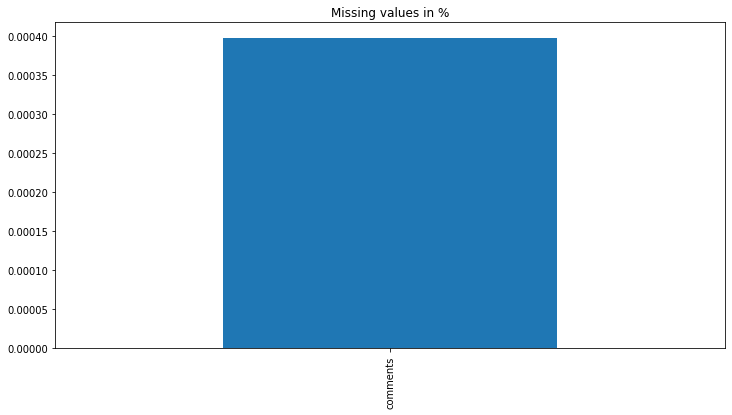

,missing_total,ratio
listing_id,0,0.000000
id,0,0.000000
date,0,0.000000
reviewer_id,0,0.000000
reviewer_name,0,0.000000
comments,68,0.000398


In [6]:
calc_missing_data(reviews, True)

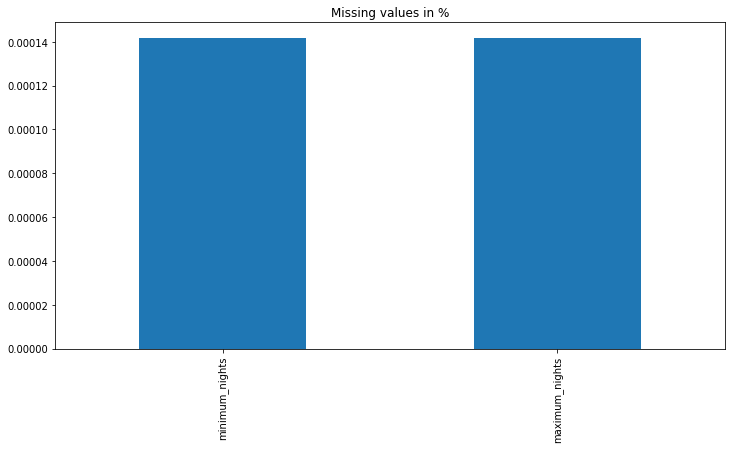

,missing_total,ratio
listing_id,0,0.000000
date,0,0.000000
available,0,0.000000
price,0,0.000000
adjusted_price,0,0.000000
minimum_nights,576,0.000142
maximum_nights,576,0.000142


In [5]:
calc_missing_data(calendar, True)

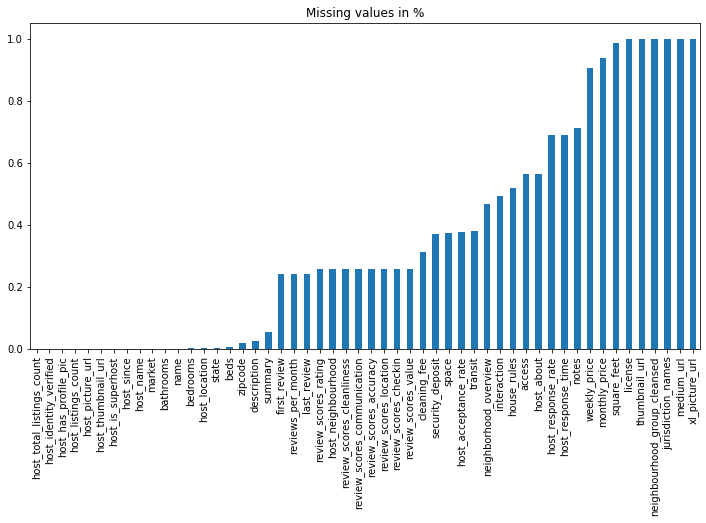

,missing_total,ratio
id,0,0.000000
listing_url,0,0.000000
scrape_id,0,0.000000
last_scraped,0,0.000000
name,20,0.001797
...,...,...
calculated_host_listings_count,0,0.000000
calculated_host_listings_count_entire_homes,0,0.000000
calculated_host_listings_count_private_rooms,0,0.000000
calculated_host_listings_count_shared_rooms,0,0.000000


In [7]:
calc_missing_data(listings, True)

In [11]:
calendar["price"] = format_price(calendar["price"])


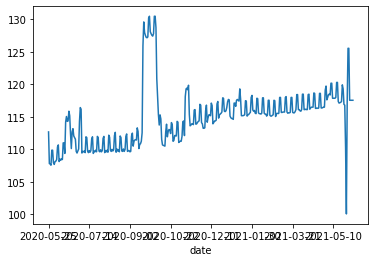

In [12]:
calendar.groupby("date")["price"].mean().plot()

In [16]:
# Get all scrape dates
scrape_dates = os.listdir("../data/raw/munich/")

In [17]:
# Load all calendar files and concatenate them
calendar = pd.DataFrame(columns=["listing_id","date"])
for date in scrape_dates:
    path = "".join(["../data/raw/munich/", date, "/calendar.csv.gz"])
    print(path)
    c = pd.read_csv(path, compression="gzip")
    c = c.drop(columns=["adjusted_price","minimum_nights","maximum_nights"])
    c["price"] = format_price(c["price"])
    calendar = calendar.merge(c, on=["listing_id", "date"], how="outer", suffixes=("","_"+date))

calendar.rename(columns={"price":"price_2019-03-15", "available":"available_2019-03-15"}, inplace=True)

../data/raw/munich/2019-03-15/calendar.csv.gz
../data/raw/munich/2019-05-22/calendar.csv.gz
../data/raw/munich/2019-06-24/calendar.csv.gz
../data/raw/munich/2019-07-16/calendar.csv.gz
../data/raw/munich/2019-08-24/calendar.csv.gz
../data/raw/munich/2019-09-24/calendar.csv.gz
../data/raw/munich/2019-10-20/calendar.csv.gz
../data/raw/munich/2019-11-25/calendar.csv.gz
../data/raw/munich/2019-12-26/calendar.csv.gz
../data/raw/munich/2020-01-22/calendar.csv.gz
../data/raw/munich/2020-02-27/calendar.csv.gz
../data/raw/munich/2020-03-19/calendar.csv.gz
../data/raw/munich/2020-04-25/calendar.csv.gz
../data/raw/munich/2020-05-24/calendar.csv.gz
../data/raw/munich/2020-06-20/calendar.csv.gz


In [23]:
import os

# Pickle calendar file that contains all the scraped data
if not os.path.exists("../data/processed"):
    os.mkdir("../data/processed/")
calendar.to_pickle("../data/processed/calendar_merged.pkl")

In [24]:
calendar.listing_id.nunique()

17496

In [2]:
calendar = pd.read_pickle("../data/processed/calendar_merged.pkl")

In [5]:
calendar["avg_price"] = calendar.loc[:,calendar.columns.str.contains("price")].mean(skipna=True, axis=1)

In [6]:
calendar["date"] = pd.to_datetime(calendar.date)
calendar["dayofweek"] = calendar["date"].dt.dayofweek

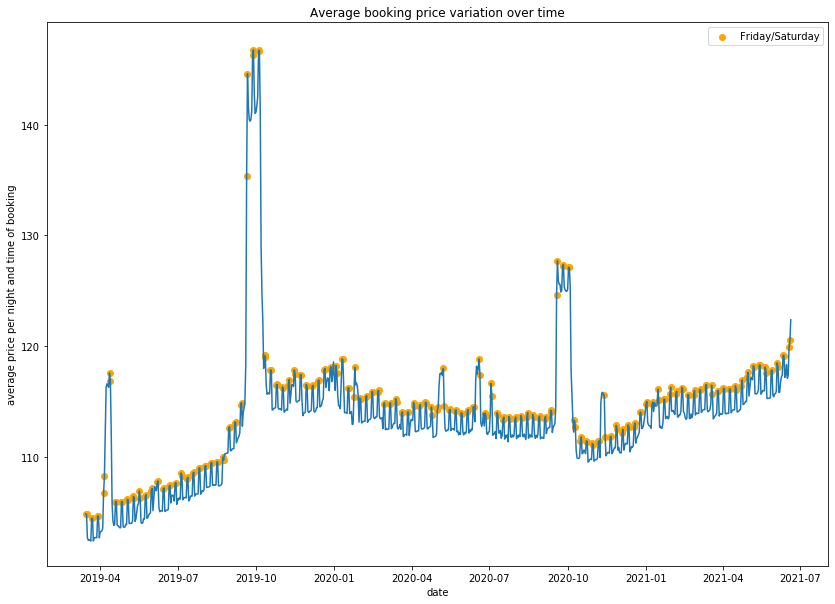

In [16]:
# Plot average daily booking prices
avg_price_weekend = calendar[calendar.dayofweek.isin([4,5])].groupby("date")["avg_price"].mean().reset_index()
avg_price = calendar.groupby("date")["avg_price"].mean().reset_index()
plt.figure(figsize=(14,10))
plt.plot(avg_price["date"], avg_price["avg_price"])
plt.scatter(avg_price_weekend["date"], avg_price_weekend["avg_price"], c="orange", label="Friday/Saturday")
plt.legend()
plt.ylabel("average price per night and time of booking")
plt.xlabel("date")
plt.title("Average booking price variation over time")
plt.savefig("../img/average_price_per_night", dpi=300)
plt.show()

Prices spike during the Oktoberfest and in one week during spring (probably due to a spring festival). Prices are generally higher on Fridays and Saturdays. Prices during Oktoberfest 2020 are higher than average but not as high as 2019. Probably due to the Corona virus.

In [7]:
calendar_melted = pd.melt(calendar.loc[:, calendar.columns.str.contains("price_|date")], id_vars=["date"]).dropna()

In [23]:
daily_mean_prices = calendar_melted.groupby(["variable","date"]).value.mean()

In [24]:
daily_mean_prices = daily_mean_prices.to_frame().reset_index()

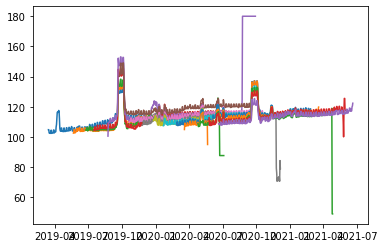

In [30]:
for var in daily_mean_prices.variable.unique():
    plt.plot(daily_mean_prices.loc[daily_mean_prices.variable==var,"date"],daily_mean_prices.loc[daily_mean_prices.variable==var,"value"])
plt.show()

The prices seem to be different when the booking has been made at different times.
Let's make a boxplot of the prices at each scrape date (represents time of booking) to get a clearer impressions of that behaviour. But first remove the Oktoberfest prices to see the trend without that outlier.

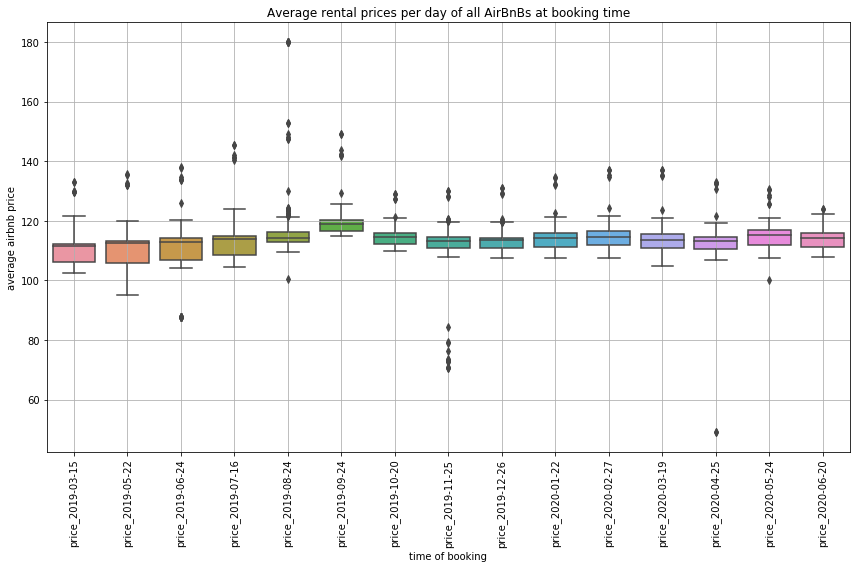

In [45]:
plt.figure(figsize=(12,8))
sns.boxplot(x="variable",y="value",data=daily_mean_prices[daily_mean_prices["date"].dt.month!=9])
plt.xticks(rotation=90)
plt.title("Average rental prices per day of all AirBnBs at booking time")
plt.xlabel("time of booking")
plt.ylabel("average airbnb price")
plt.grid(True)
plt.tight_layout()
plt.savefig("../img/prices_at_booking_time", dpi=300)

In [ ]:
The boxplot shows that even without the prices during the Oktoberfest, booking during September and few weeks before and after the Oktoberfest seems to be more expensive.